<a href="https://colab.research.google.com/github/Selvapriya412004/ANALYSIS-OF-ALL-MAIL-INCLUDING-SPAM-AND-TRASH/blob/main/ANALYSIS_OF_ALL_MAIL_INCLUDING_SPAM_AND_TRASH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import mailbox
mboxfile=('/All mail Including Spam and Trash.mbox')
mbox = mailbox.mbox(mboxfile)
mbox


In [6]:
for key in mbox :
  print(key)

In [7]:
import csv

In [8]:
with open('mailbox.csv', 'w') as outputfile:
  writer = csv.writer(outputfile)
  writer.writerow(['subject','from','date','to','label','thread'])
  for message in mbox:
    writer.writerow([
    message['subject'],
    message['from'],
    message['date'],
    message['to'],
    message['X-Gmail-Labels'],
    message['X-GM-THRID']
  ]
)

In [9]:
dfs = pd.read_csv('mailbox.csv', names=['subject', 'from', 'date', 'to','label', 'thread'])

In [10]:
dfs.dtypes

subject    object
from       object
date       object
to         object
label      object
thread     object
dtype: object

In [11]:
#converting the date
dfs['date'] = dfs['date'].apply(lambda x: pd.to_datetime(x,errors='coerce', utc=True))

In [12]:
# Removing NaN values

dfs = dfs[dfs['date'].notna()]
dfs.to_csv('gmail.csv')

In [13]:
#Applying descriptive statistics
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   subject  0 non-null      object        
 1   from     0 non-null      object        
 2   date     0 non-null      datetime64[ns]
 3   to       0 non-null      object        
 4   label    0 non-null      object        
 5   thread   0 non-null      object        
dtypes: datetime64[ns](1), object(5)
memory usage: 0.0+ bytes


In [15]:
dfs.head(10)

,subject,from,date,to,label,thread


In [16]:
import re
import re
def extract_email_ID(string):
  email = re.findall(r'<(.+?)>', string)
  if not email:
    email = list(filter(lambda y: '@' in y, string.split()))
  return email[0] if email else np.nan


In [17]:
dfs['from'] = dfs['from'].apply(lambda x: extract_email_ID(x))

In [18]:
myemail = '953621243051@ritrjpm.ac.in'
dfs['label'] = dfs['from'].apply(lambda x: 'sent' if x==myemail else 'inbox')

In [19]:
#Dropping columns
dfs.drop(columns='to', inplace=True)

In [20]:
dfs.head(10)

,subject,from,date,label,thread


In [21]:
import pytz
def refactor_timezone(x):
  est = pytz.timezone('US/Eastern')
  return x.astimezone(est)

In [22]:
dfs['date'] = dfs['date'].apply(lambda x: refactor_timezone(x))

In [23]:
#convert the day of the week variable into the name of the day, as in, Saturday, Sunday, and so on
dfs['dayofweek'] = dfs['date'].apply(lambda x: x.day_name())
dfs['dayofweek'] = pd.Categorical(dfs['dayofweek'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday'], ordered=True)

In [24]:
#same process for the time of the day
dfs['timeofday'] = dfs['date'].apply(lambda x: x.hour + x.minute/60+ x.second/3600)

In [25]:
dfs['hour'] = dfs['date'].apply(lambda x: x.hour)

In [26]:
dfs['year_int'] = dfs['date'].apply(lambda x: x.year)

In [27]:
dfs['year'] = dfs['date'].apply(lambda x: x.year +x.dayofyear/365.25)

In [28]:
dfs.index = dfs['date']
del dfs['date']
#Number of emails
print(dfs.index.min().strftime('%a, %d %b %Y %I:%M %p'))
print(dfs.index.max().strftime('%a, %d %b %Y %I:%M %p'))
print(dfs['label'].value_counts())

In [40]:
#two sub-dataframe—one for sent emails and another for received emails:
sent = dfs[dfs['label']=='sent']
received = dfs[dfs['label']=='inbox']

In [41]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

In [42]:
#create a function that takes a dataframe as an input and creates a plot
def plot_todo_vs_year(df, ax, color='C0', s=0.5, title=''):
  ind = np.zeros(len(df), dtype='bool')
  est = pytz.timezone('US/Eastern')
  df[~ind].plot.scatter('year', 'timeofday', s=s, alpha=0.6, ax=ax,color=color)
  ax.set_ylim(0, 24)
  ax.yaxis.set_major_locator(MaxNLocator(8))
  ax.set_yticklabels([datetime.datetime.strptime(str(int(np.mod(ts,24))), "%H").strftime("%I %p") for ts in ax.get_yticks()]);
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_title(title)
  ax.grid(ls=':', color='k')
  return ax

<ipython-input-42-375026574b8d>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([datetime.datetime.strptime(str(int(np.mod(ts,24))), "%H").strftime("%I %p") for ts in ax.get_yticks()]);


<Axes: title={'center': 'Received'}>

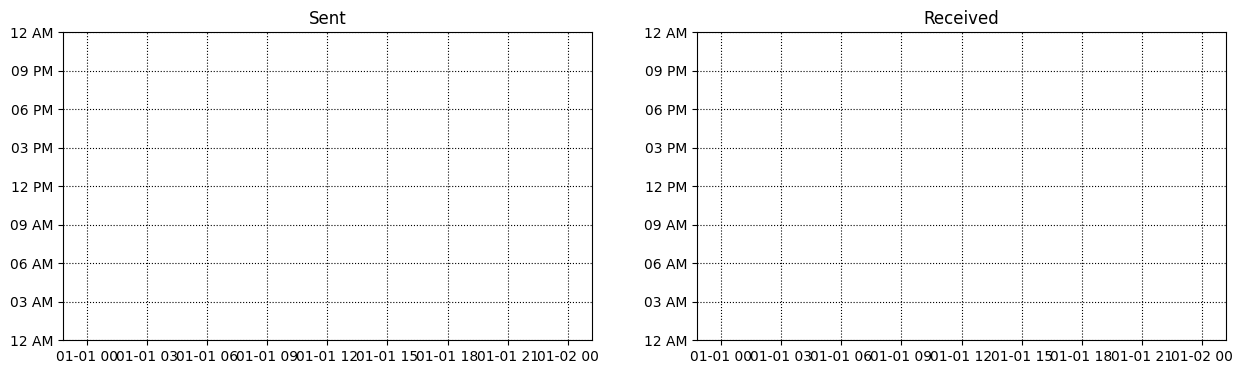

In [43]:
import datetime
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
plot_todo_vs_year(sent, ax[0], title='Sent')
plot_todo_vs_year(received, ax[1], title='Received')

In [ ]:
#Average emails per day and hour

In [44]:
def plot_number_perday_per_year(df, ax, label=None, dt=0.3,**plot_kwargs):
  year = df[df['year'].notna()]['year'].values
  T = year.max() - year.min()
  bins = int(T / dt)
  weights = 1 / (np.ones_like(year) * dt * 365.25)
  ax.hist(year, bins=bins, weights=weights, label=label,**plot_kwargs);
  ax.grid(ls=':', color='k')

In [45]:
#creates a function that plots the average number of emails per day
def plot_number_perdhour_per_year(df, ax, label=None, dt=1,smooth=False,weight_fun=None, **plot_kwargs):
  tod = df[df['timeofday'].notna()]['timeofday'].values
  year = df[df['year'].notna()]['year'].values
  Ty = year.max() - year.min()
  T = tod.max() - tod.min()
  bins = int(T / dt)
  if weight_fun is None:
    weights = 1 / (np.ones_like(tod) * Ty * 365.25 / dt)
  else:
    weights = weight_fun(df)
  if smooth:
    hst, xedges = np.histogram(tod, bins=bins,weights=weights);
    x = np.delete(xedges, -1) + 0.5*(xedges[1] - xedges[0])
    hst = ndimage.gaussian_filter(hst, sigma=0.75)
    f = interp1d(x, hst, kind='cubic')
    x = np.linspace(x.min(), x.max(), 10000)
    hst = f(x)
    ax.plot(x, hst, label=label, **plot_kwargs)
  else:
    ax.hist(tod, bins=bins, weights=weights, label=label,**plot_kwargs);
  ax.grid(ls=':', color='k')
  orientation = plot_kwargs.get('orientation')
  if orientation is None or orientation == 'vertical':
    ax.set_xlim(0, 24)
    ax.xaxis.set_major_locator(MaxNLocator(8))
    ax.set_xticklabels([datetime.datetime.strptime(str(int(np.mod(ts,24))), "%H").strftime("%I %p") for ts in ax.get_xticks()]);
  elif orientation == 'horizontal':
    ax.set_ylim(0, 24)
    ax.yaxis.set_major_locator(MaxNLocator(8))
  ax.set_yticklabels([datetime.datetime.strptime(str(int(np.mod(ts, 24))), "%H").strftime("%I %p") for ts in ax.get_yticks()]);

In [ ]:
# create a class that plots the time of the day versus year for all the emails within the given timeframe
class TriplePlot:
  def __init__(self):
    gs = gridspec.GridSpec(6, 6)
    self.ax1 = plt.subplot(gs[2:6, :4])
    self.ax2 = plt.subplot(gs[2:6, 4:6], sharey=self.ax1)
    plt.setp(self.ax2.get_yticklabels(), visible=False);
    self.ax3 = plt.subplot(gs[:2, :4])
    plt.setp(self.ax3.get_xticklabels(), visible=False);
  def plot(self, df, color='darkblue', alpha=0.8, markersize=0.5,yr_bin=0.1, hr_bin=0.5):
    plot_todo_vs_year(df, self.ax1, color=color, s=markersize)
    plot_number_perdhour_per_year(df, self.ax2, dt=hr_bin,color=color, alpha=alpha, orientation='horizontal')
    self.ax2.set_xlabel('Average emails per hour')
    plot_number_perday_per_year(df, self.ax3, dt=yr_bin,color=color, alpha=alpha)
    self.ax3.set_ylabel('Average emails per day')

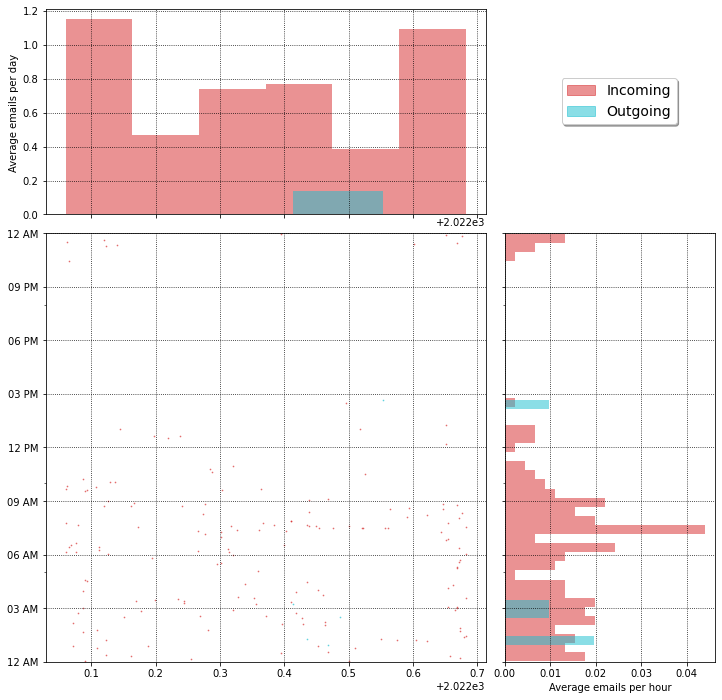

In [ ]:
#instantiate the class to plot the graph:
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import datetime
plt.figure(figsize=(12,12));
tpl = TriplePlot()
tpl.plot(received, color='C13', alpha=0.5)
tpl.plot(sent, color='C9', alpha=0.5)
p1 = mpatches.Patch(color='C13', label='Incoming', alpha=0.5)
p2 = mpatches.Patch(color='C9', label='Outgoing', alpha=0.5)
plt.legend(handles=[p1, p2], bbox_to_anchor=[1.45, 0.7],fontsize=14, shadow=True);

In [ ]:
#Number of emails per day

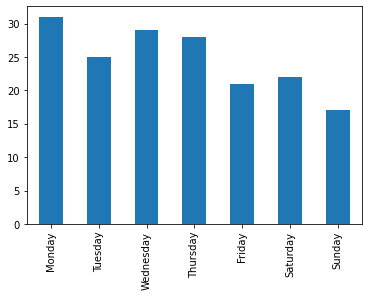

In [ ]:
#find the busiest day of the week in terms of emails:
counts = dfs.dayofweek.value_counts(sort=False)
counts.plot(kind='bar')

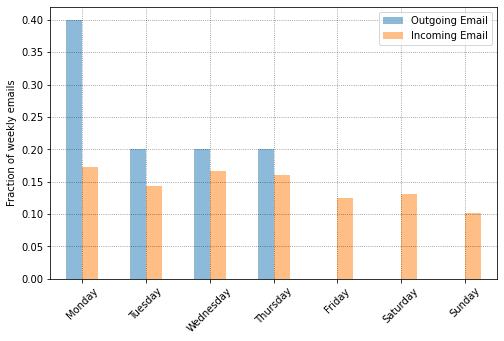

In [ ]:
sdw = sent.groupby('dayofweek').size() / len(sent)
rdw = received.groupby('dayofweek').size() / len(received)
df_tmp = pd.DataFrame(data={'Outgoing Email': sdw, 'Incoming Email':rdw})
df_tmp.plot(kind='bar', rot=45, figsize=(8,5), alpha=0.5)
plt.xlabel('');
plt.ylabel('Fraction of weekly emails');
plt.grid(ls=':', color='k', alpha=0.5)

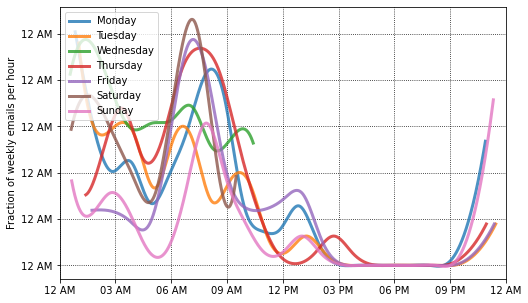

In [ ]:
import scipy.ndimage
from scipy.interpolate import interp1d
import datetime
plt.figure(figsize=(8,5))
ax = plt.subplot(111)
for ct, dow in enumerate(dfs.dayofweek.cat.categories):
  df_r = received[received['dayofweek']==dow]
  weights = np.ones(len(df_r)) / len(received)
  wfun = lambda x: weights
  plot_number_perdhour_per_year(df_r, ax, dt=1, smooth=True, color=f'C{ct}', alpha=0.8, lw=3, label=dow, weight_fun=wfun)
  df_s = sent[sent['dayofweek']==dow]
  weights = np.ones(len(df_s)) / len(sent)
  wfun = lambda x: weights
  #plot_number_perdhour_per_year(df_s, ax, dt=1, smooth=True, color=f'C{ct}', alpha=0.8, lw=2, label=dow, ls='--', weight_fun=wfun)

ax.set_ylabel('Fraction of weekly emails per hour')
plt.legend(loc='upper left')

In [ ]:
from wordcloud import WordCloud
df_no_arxiv = dfs[dfs['from'] != 'no-reply@arXiv.org']
text = ' '.join(map(str, sent['subject'].values))
from wordcloud import WordCloud
df_no_arxiv = dfs[dfs['from'] != 'no-reply@arXiv.org']
text = ' '.join(map(str, sent['subject'].values))

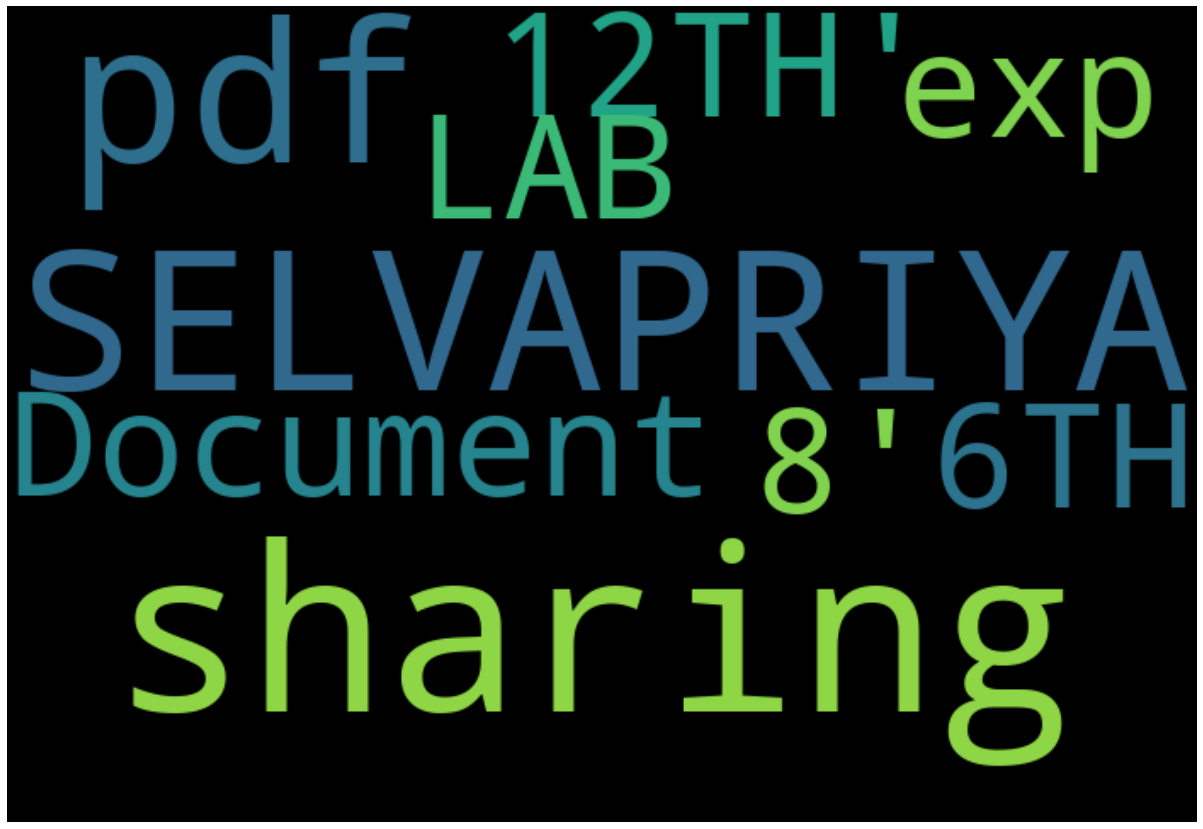

In [ ]:
#plot the word cloud:
stopwords = ['Re', 'Fwd', '3A_']
wrd = WordCloud(width=700, height=480, margin=0, collocations=False)
for sw in stopwords:
  wrd.stopwords.add(sw)
wordcloud = wrd.generate(text)
plt.figure(figsize=(25,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)